# Imports

# Dataset
https://www.kaggle.com/competitions/ieee-final-round/data

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2

# Exploratory data analysis

In [5]:
TRAIN_PATH = '../input/ieee-final-round/train_features/'

In [6]:
train_data = pd.read_csv('../input/ieee-final-round/train_set.csv')
train_data.head()

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000004,train_features/ZJ000004.jpg,S0036
4,ZJ000006,train_features/ZJ000006.jpg,S0060


In [7]:
# train_data['site'].nunique()
# train_data.shape

In [8]:
train_data['filepath'] = train_data['filepath'].apply(lambda x :  TRAIN_PATH +str(x))
train_label = pd.read_csv('../input/ieee-final-round/train_labels.csv')
train_data['label'] = train_label.drop('id',axis=1).values.argmax(axis = 1)

In [9]:
train_data.head()

,id,filepath,site,label
0,ZJ000000,../input/ieee-final-round/train_features/train...,S0120,1
1,ZJ000001,../input/ieee-final-round/train_features/train...,S0069,6
2,ZJ000002,../input/ieee-final-round/train_features/train...,S0009,1
3,ZJ000004,../input/ieee-final-round/train_features/train...,S0036,5
4,ZJ000006,../input/ieee-final-round/train_features/train...,S0060,3


In [10]:
categories_name = {0:'antelope_duiker'	,
                   1:'bird'	,
                   2:'blank',
                   3:'civet_genet'	,
                   4:'hog'	,
                   5:'leopard'	,
                   6:'monkey_prosimian'	,
                   7:'rodent'}
train_data['label_name'] = train_data['label'].map(categories_name)
train_data.head()

,id,filepath,site,label,label_name
0,ZJ000000,../input/ieee-final-round/train_features/train...,S0120,1,bird
1,ZJ000001,../input/ieee-final-round/train_features/train...,S0069,6,monkey_prosimian
2,ZJ000002,../input/ieee-final-round/train_features/train...,S0009,1,bird
3,ZJ000004,../input/ieee-final-round/train_features/train...,S0036,5,leopard
4,ZJ000006,../input/ieee-final-round/train_features/train...,S0060,3,civet_genet


In [11]:
# size =[]
# for file in train_data['filepath']: 
#     image = plt.imread(file)
#     size.append(image.shape)
# pd.Series(size).value_counts()
# (540, 960, 3)    5331
# (360, 640, 3)    4704
# (360, 640)       1009
# (335, 640, 3)     821
# (240, 360)        304
# (240, 360, 3)     158
# (515, 960, 3)     155
# (120, 160, 3)      66
# (335, 640)         65
# (120, 160)         61
# (215, 360, 3)      54
# (215, 360)          1
# dtype: int64

In [12]:
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    horizontal_flip=True,
    width_shift_range = 0.1,
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
#     preprocessing_function = efn.preprocess_input
)

In [13]:
train_df = train_data[['filepath','label_name']]

In [14]:
train_data1 = train_df.iloc[2000:]
val_data = train_df.iloc[:2000]

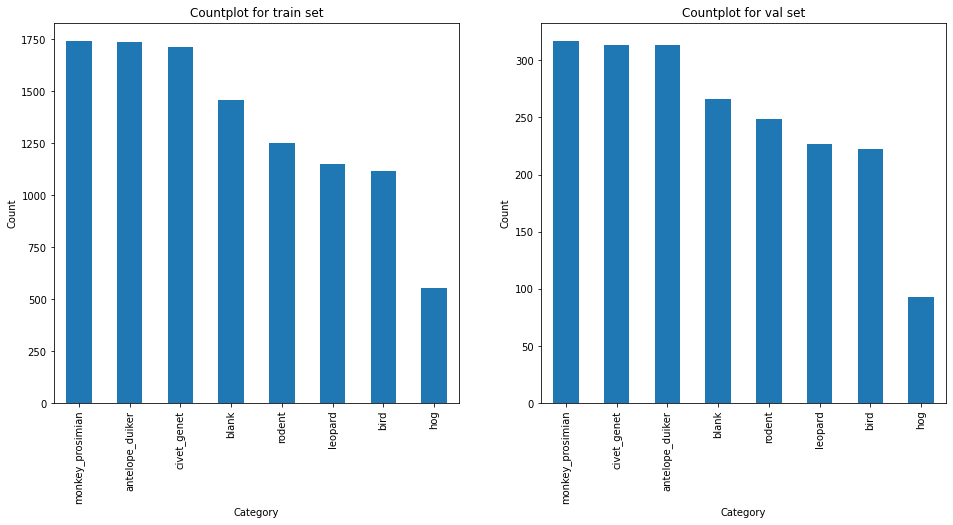

In [15]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
train_data1['label_name'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
val_data['label_name'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

In [16]:
TARGET_SIZE =   (224,224) # (360,640)  
# input size for vgg 16 = (224,224), keep it same as the input size of the pretrained model for better performance
BATCH_SIZE = 64

In [ ]:
def fun(image):
    image = image[:-20,:]
    return image

In [17]:
train_set = train_gen.flow_from_dataframe(
    train_data1, 
    x_col='filepath',
    y_col='label_name',
    target_size=TARGET_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    val_data, 
    x_col='filepath',
    y_col='label_name',
    target_size=TARGET_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)

Found 10729 validated image filenames belonging to 8 classes.
Found 2000 validated image filenames belonging to 8 classes.


In [18]:
class_dict = {v:k for k,v in train_set.class_indices.items()}

In [19]:
train_set.image_shape,val_set.image_shape

((224, 224, 3), (224, 224, 3))

In [20]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

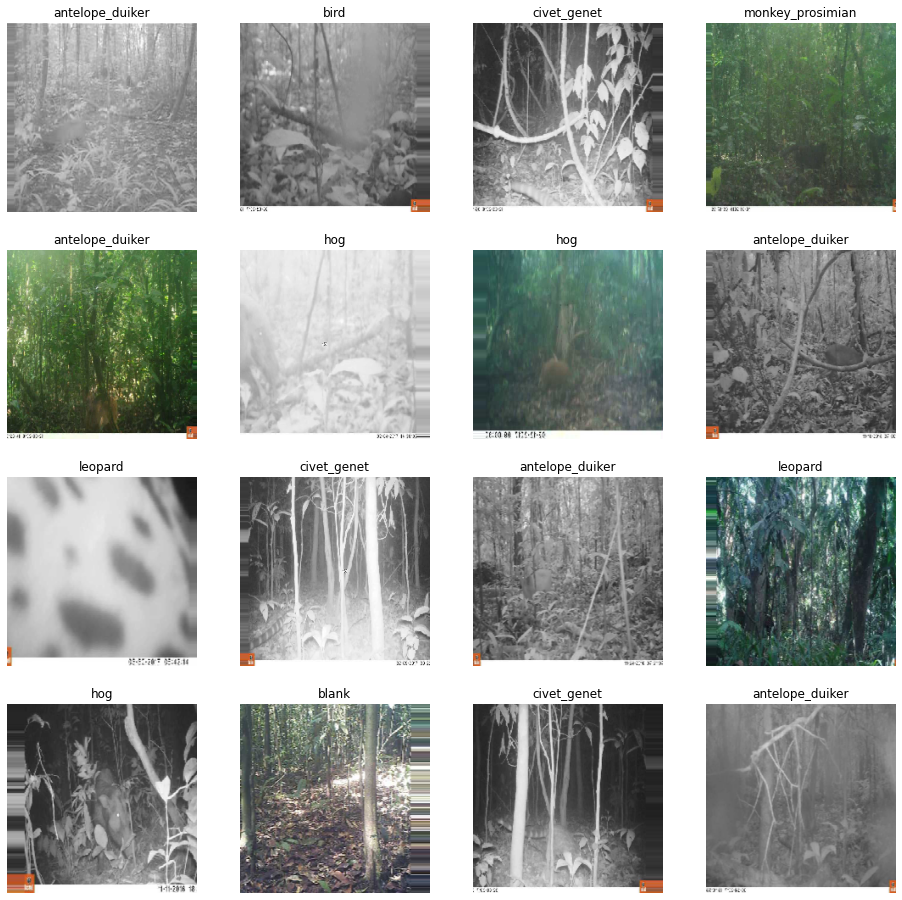

In [21]:
see_examples(train_set)

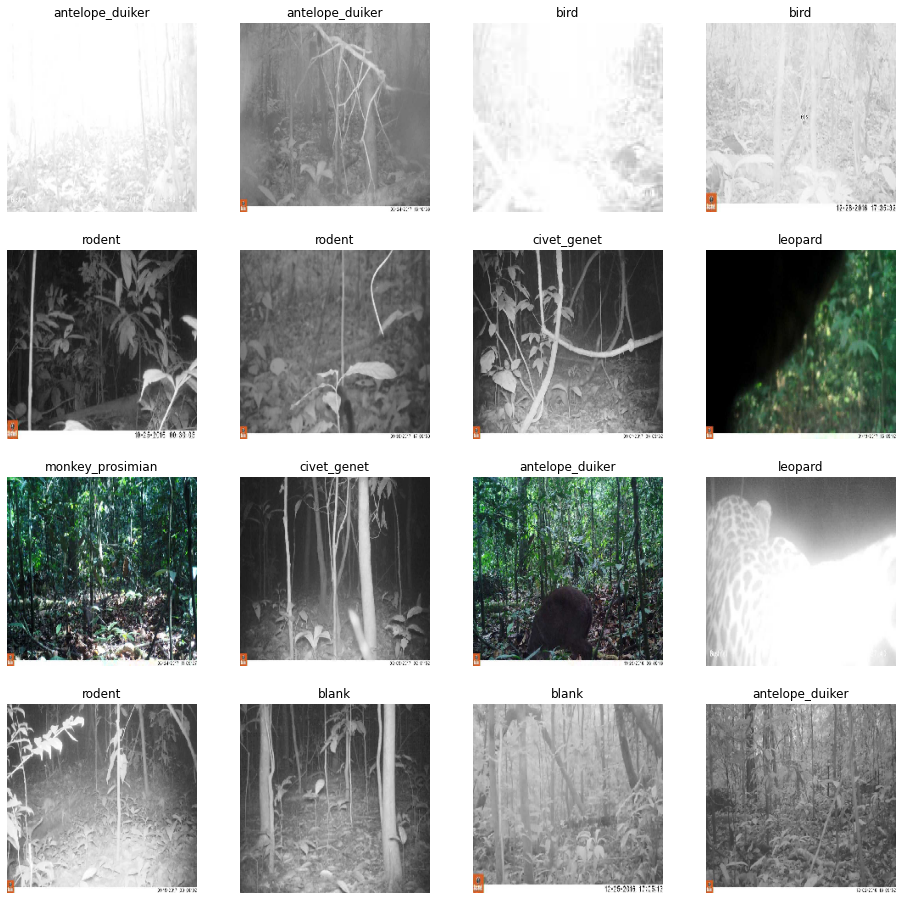

In [22]:
see_examples(val_set)

# Model Building

In [28]:
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(TARGET_SIZE[0],TARGET_SIZE[1], 3))
# conv_base.trainable=False 

In [29]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(TARGET_SIZE[0],TARGET_SIZE[1], 3))
conv_base.trainable=False 

In [30]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [31]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block6a_expand_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [32]:
model = Sequential([
    conv_base,
    Flatten(),
    
    Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='softmax')
])

In [33]:
# KerasModel = Sequential([
#         Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(360,640,3)),
# #         Conv2D(150,kernel_size=(3,3),activation='relu'),
#         MaxPool2D(4,4),
#         Conv2D(120,kernel_size=(3,3),activation='relu'),    
# #         Conv2D(80,kernel_size=(3,3),activation='relu'),    
#         Conv2D(50,kernel_size=(3,3),activation='relu'),
#         MaxPool2D(4,4),
#         Flatten() ,    
#         Dense(120,activation='relu') ,    
#         Dense(100,activation='relu') ,    
#         Dense(50,activation='relu') ,        
#         Dropout(rate=0.5) ,            
#         Dense(8,activation='softmax') ,    
#         ])
# KerasModel.summary()

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               32113152  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [35]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=10),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [36]:
metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=8), 
    Precision(), 
    Recall(), 
    AUC()
]

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
train_set.n//train_set.batch_size

In [ ]:
history = model.fit(train_set,epochs=100, steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_data=val_set, validation_steps=val_set.n//val_set.batch_size,
                   callbacks=callbacks)

Epoch 1/100
167/167 [==============================] - 204s 1s/step - loss: 0.4179 - categorical_accuracy: 0.8516 - f1_score: 0.8602 - precision: 0.8977 - recall: 0.8103 - auc: 0.9860 - val_loss: 0.6283 - val_categorical_accuracy: 0.8085 - val_f1_score: 0.8165 - val_precision: 0.8416 - val_recall: 0.7823 - val_auc: 0.9730
Epoch 2/100
167/167 [==============================] - 204s 1s/step - loss: 0.4117 - categorical_accuracy: 0.8514 - f1_score: 0.8607 - precision: 0.8979 - recall: 0.8085 - auc: 0.9866 - val_loss: 0.5463 - val_categorical_accuracy: 0.8271 - val_f1_score: 0.8326 - val_precision: 0.8599 - val_recall: 0.7979 - val_auc: 0.9775
Epoch 3/100
167/167 [==============================] - 213s 1s/step - loss: 0.4072 - categorical_accuracy: 0.8590 - f1_score: 0.8688 - precision: 0.9003 - recall: 0.8157 - auc: 0.9865 - val_loss: 0.5275 - val_categorical_accuracy: 0.8327 - val_f1_score: 0.8431 - val_precision: 0.8777 - val_recall: 0.7848 - val_auc: 0.9783
Epoch 4/100
167/167 [=======

In [41]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,auc,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,val_auc
0,1.419073,0.455509,"[0.3310932, 0.21654338, 0.15338646, 0.7447109,...",0.737468,0.267604,0.850997,1.231168,0.531754,"[0.3633491, 0.29323307, 0.13731343, 0.7836611,...",0.840541,0.313508,0.890906
1,1.318643,0.489076,"[0.35807264, 0.23593222, 0.19476025, 0.7752024...",0.749884,0.304173,0.871301,1.126736,0.539819,"[0.4095563, 0.32653058, 0.12418301, 0.8012139,...",0.843416,0.358367,0.909420
2,1.224379,0.524426,"[0.37376586, 0.368, 0.27960056, 0.7879828, 0.6...",0.766122,0.343085,0.889276,1.075833,0.568548,"[0.41124782, 0.26666665, 0.22155687, 0.7999999...",0.873072,0.370968,0.916108
3,1.204791,0.539240,"[0.39780772, 0.36302522, 0.31159082, 0.7936508...",0.772279,0.359962,0.893478,1.041963,0.598286,"[0.41566265, 0.5329341, 0.17647058, 0.79425836...",0.781222,0.431956,0.920149
4,1.165343,0.550586,"[0.4060495, 0.43737164, 0.28966177, 0.80673707...",0.779902,0.386404,0.900773,1.034644,0.636593,"[0.4218513, 0.68888885, 0.2546584, 0.816619, 0...",0.868476,0.419355,0.923189


In [42]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

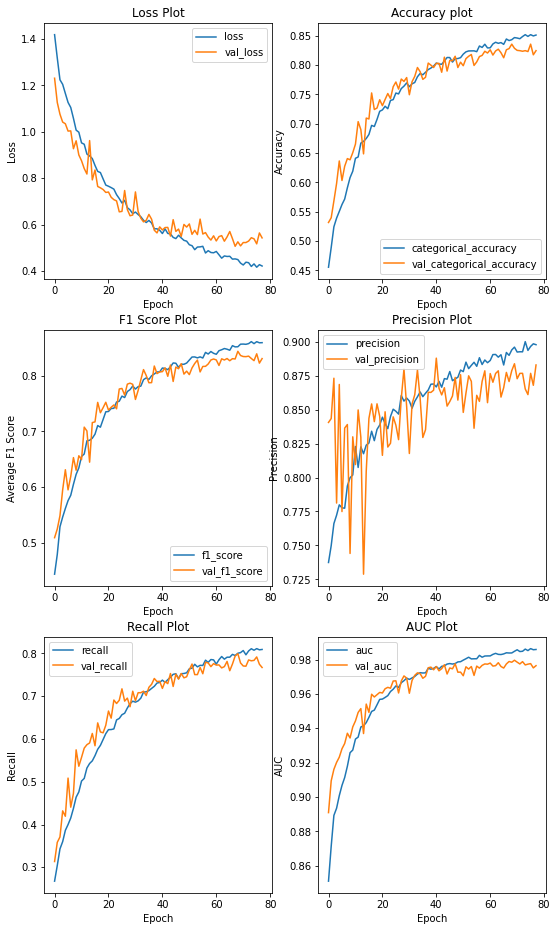

In [44]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
history_df[['auc','val_auc']].plot(ax=ax[2,1],xlabel='Epoch',ylabel='AUC',title='AUC Plot')
plt.show()

# Evaluating the model

In [45]:
best_model = load_model('best_model.h5')

In [46]:
val_set_final = val_gen.flow_from_dataframe(
    val_data,x_col='filepath',
    y_col='label_name',
    class_mode='categorical',
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE, 
    shuffle=False)
val_loss,val_acc, val_f1, val_precision, val_recall, val_auc = best_model.evaluate(val_set_final)

Found 2000 validated image filenames belonging to 8 classes.
32/32 [==============================] - 17s 479ms/step - loss: 0.5076 - categorical_accuracy: 0.8270 - f1_score: 0.8293 - precision: 0.8695 - recall: 0.7930 - auc: 0.9788


In [47]:
val_preds = best_model.predict(val_set_final)
val_preds = val_preds.argmax(axis=1)
val_data.head()

,filepath,label_name
0,../input/ieee-final-round/train_features/train...,bird
1,../input/ieee-final-round/train_features/train...,monkey_prosimian
2,../input/ieee-final-round/train_features/train...,bird
3,../input/ieee-final-round/train_features/train...,leopard
4,../input/ieee-final-round/train_features/train...,civet_genet


In [48]:
val_set.class_indices

{'antelope_duiker': 0,
 'bird': 1,
 'blank': 2,
 'civet_genet': 3,
 'hog': 4,
 'leopard': 5,
 'monkey_prosimian': 6,
 'rodent': 7}

In [49]:
val_data['Label'] = val_data['label_name'].map(val_set.class_indices)
val_data['Predicted'] = val_preds
val_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,filepath,label_name,Label,Predicted
0,../input/ieee-final-round/train_features/train...,bird,1,1
1,../input/ieee-final-round/train_features/train...,monkey_prosimian,6,6
2,../input/ieee-final-round/train_features/train...,bird,1,1
3,../input/ieee-final-round/train_features/train...,leopard,5,5
4,../input/ieee-final-round/train_features/train...,civet_genet,3,3


In [50]:
val_set_final.class_indices

{'antelope_duiker': 0,
 'bird': 1,
 'blank': 2,
 'civet_genet': 3,
 'hog': 4,
 'leopard': 5,
 'monkey_prosimian': 6,
 'rodent': 7}

In [51]:
conf_mat = confusion_matrix(y_true=val_data['Label'], y_pred=val_data['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=val_set_final.class_indices.keys(), columns=val_set_final.class_indices.keys())

In [52]:
conf_mat

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
antelope_duiker,209,11,21,10,3,4,38,17
bird,4,215,0,0,0,0,1,2
blank,67,22,93,17,0,12,34,21
civet_genet,0,0,3,294,0,0,0,16
hog,1,0,0,0,92,0,0,0
leopard,1,0,2,0,0,221,2,1
monkey_prosimian,17,7,1,0,0,0,292,0
rodent,1,1,1,6,1,0,1,238


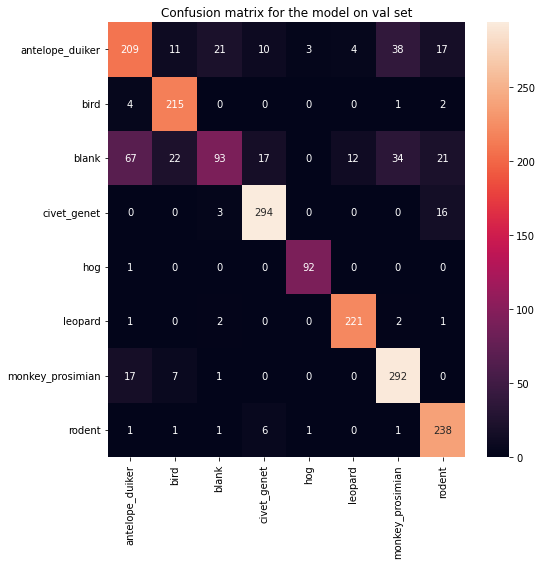

In [53]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on val set')
plt.show()

# Submission 

In [54]:
TEST_PATH = '../input/ieee-final-round/test_features/'

In [55]:
test_df = pd.read_csv('../input/ieee-final-round/test_set.csv')
test_df.head()

,id,filepath,site
0,ZJ000003,test_features/ZJ000003.jpg,S0008
1,ZJ000005,test_features/ZJ000005.jpg,S0019
2,ZJ000011,test_features/ZJ000011.jpg,S0014
3,ZJ000012,test_features/ZJ000012.jpg,S0080
4,ZJ000017,test_features/ZJ000017.jpg,S0080


In [56]:
test_df['filepath'] = test_df['filepath'].apply(lambda x :  TEST_PATH +str(x))

In [57]:
test_label = pd.read_csv('../input/ieee-final-round/sample_submission.csv')
test_label.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000003,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.5
1,ZJ000005,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.5
2,ZJ000011,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.5
3,ZJ000012,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.5
4,ZJ000017,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.5


In [58]:
test_df['label'] = test_label.drop('id',axis=1).values.argmax(axis = 1)
test_df['label_name'] = test_df['label'].map(categories_name)
test_df.head()

,id,filepath,site,label,label_name
0,ZJ000003,../input/ieee-final-round/test_features/test_f...,S0008,7,rodent
1,ZJ000005,../input/ieee-final-round/test_features/test_f...,S0019,7,rodent
2,ZJ000011,../input/ieee-final-round/test_features/test_f...,S0014,7,rodent
3,ZJ000012,../input/ieee-final-round/test_features/test_f...,S0080,7,rodent
4,ZJ000017,../input/ieee-final-round/test_features/test_f...,S0080,7,rodent


In [59]:
final_test_set = val_gen.flow_from_dataframe(
    test_df,x_col='filepath',
    y_col='label_name',
    class_mode='categorical',
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

Found 3759 validated image filenames belonging to 1 classes.


In [60]:
final_test_preds = best_model.predict(final_test_set)

In [61]:
final_test_preds[:5]

array([[1.6781634e-01, 4.9495000e-02, 3.9331368e-01, 2.5830664e-02,
        9.3808345e-02, 1.4142736e-02, 1.5211215e-02, 2.4038209e-01],
       [2.7320579e-02, 2.2465514e-08, 3.7124316e-04, 1.7605837e-05,
        9.7228259e-01, 7.9193470e-08, 6.5936938e-06, 1.3250155e-06],
       [2.2931404e-03, 1.2116388e-03, 1.1492519e-01, 3.6163314e-05,
        3.5588939e-05, 8.8108349e-01, 7.0641108e-05, 3.4412890e-04],
       [3.4461898e-01, 2.2480156e-02, 1.9757494e-01, 7.0476037e-04,
        1.7946860e-02, 4.6422319e-03, 4.0113497e-01, 1.0897201e-02],
       [2.5375798e-01, 9.6947467e-03, 6.7395493e-02, 1.8261950e-02,
        6.1187118e-01, 2.1756329e-03, 1.9761305e-02, 1.7081739e-02]],
      dtype=float32)

In [62]:
test_label.columns

Index(['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog',
       'leopard', 'monkey_prosimian', 'rodent'],
      dtype='object')

In [63]:
submission = pd.DataFrame(final_test_preds, columns =['antelope_duiker',
                                         'bird', 'blank', 
                                         'civet_genet', 
                                         'hog','leopard', 
                                         'monkey_prosimian',
                                         'rodent']) 
submission.insert(0,'id',test_label['id'])

In [64]:
submission.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000003,0.167816,4.949500e-02,0.393314,0.025831,0.093808,1.414274e-02,0.015211,0.240382
1,ZJ000005,0.027321,2.246551e-08,0.000371,0.000018,0.972283,7.919347e-08,0.000007,0.000001
2,ZJ000011,0.002293,1.211639e-03,0.114925,0.000036,0.000036,8.810835e-01,0.000071,0.000344
3,ZJ000012,0.344619,2.248016e-02,0.197575,0.000705,0.017947,4.642232e-03,0.401135,0.010897
4,ZJ000017,0.253758,9.694747e-03,0.067395,0.018262,0.611871,2.175633e-03,0.019761,0.017082


In [65]:
submission.to_csv('final_round_ieee(50).csv', index=False)